In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from keras.applications import DenseNet201

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# Set the data path and categories
train_data_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/train'
test_data_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/test'
val_data_path = '/kaggle/input/knee-osteoarthritis-dataset-with-severity/val'

categories = os.listdir(train_data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 128

# Load the training images and labels
train_data = []
train_label = []

for category in categories:
    folder_path = os.path.join(train_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)
            resized = cv2.resize(gray, (img_size, img_size))
            train_data.append(resized)
            train_label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

# Load the testing images and labels
test_data = []
test_label = []

for category in categories:
    folder_path = os.path.join(test_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)
            resized = cv2.resize(gray, (img_size, img_size))
            test_data.append(resized)
            test_label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

# Load the validation images and labels
val_data = []
val_label = []

for category in categories:
    folder_path = os.path.join(val_data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)
            resized = cv2.resize(gray, (img_size, img_size))
            val_data.append(resized)
            val_label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [3]:
# Convert the data and labels to numpy arrays
train_data = np.array(train_data) / 255.0
train_data_rgb = np.repeat(train_data[..., np.newaxis], 3, -1)
train_label = np.array(train_label)
train_label = np_utils.to_categorical(train_label)

test_data = np.array(test_data) / 255.0
test_data_rgb = np.repeat(test_data[..., np.newaxis], 3, -1)
test_label = np.array(test_label)
test_label = np_utils.to_categorical(test_label)

val_data = np.array(val_data) / 255.0
val_data_rgb = np.repeat(val_data[..., np.newaxis], 3, -1)
val_label = np.array(val_label)
val_label = np_utils.to_categorical(val_label)

# Define the data generator for training
datagen_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = datagen_train.flow(train_data_rgb, train_label, batch_size=16)

In [4]:
# Define the model architecture
model = Sequential()

# DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = True

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 5)                 9605      
                                                                 
Total params: 18,331,589
Trainable params: 18,102,533
Non-trainable params: 229,056
_________________________________________________________________


In [5]:
# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
# Train the model
history = model.fit(train_generator,
                    epochs=90,
                    validation_data=(val_data_rgb, val_label),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/90
362/362 [==============================] - ETA: 0s - loss: 0.8072 - accuracy: 0.6620
Epoch 1: val_accuracy did not improve from 0.67433
362/362 [==============================] - 49s 135ms/step - loss: 0.8072 - accuracy: 0.6620 - val_loss: 0.8817 - val_accuracy: 0.6295
Epoch 2/90
362/362 [==============================] - ETA: 0s - loss: 0.7868 - accuracy: 0.6731
Epoch 2: val_accuracy did not improve from 0.67433
362/362 [==============================] - 46s 127ms/step - loss: 0.7868 - accuracy: 0.6731 - val_loss: 1.0568 - val_accuracy: 0.5908
Epoch 3/90
362/362 [==============================] - ETA: 0s - loss: 0.7792 - accuracy: 0.6755
Epoch 3: val_accuracy did not improve from 0.67433
362/362 [==============================] - 48s 133ms/step - loss: 0.7792 - accuracy: 0.6755 - val_loss: 0.8917 - val_accuracy: 0.6053
Epoch 4/90
362/362 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.6668
Epoch 4: val_accuracy did not improve from 0.67433
362/362 [=

In [9]:
# Load the best weights
model.load_weights('/kaggle/working/model.h5')

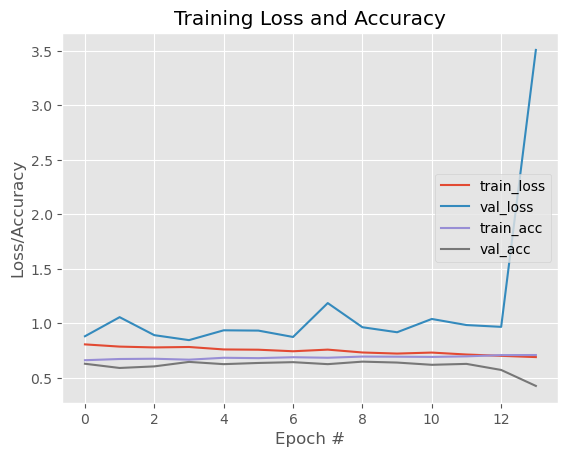

In [10]:
# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("DenseNet201_Model")

In [11]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(test_data_rgb, test_label, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

# Get the predictions for the test set
predictions = model.predict(test_data_rgb)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the classification report
report = classification_report(np.argmax(test_label, axis=1), predicted_labels)
print(report)

Test loss: 0.7874870896339417
Test accuracy: 0.6757246255874634
52/52 [==============================] - 6s 52ms/step
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       447
           1       0.68      0.89      0.77       639
           2       0.78      0.80      0.79       223
           3       0.36      0.10      0.15       296
           4       0.80      0.92      0.85        51

    accuracy                           0.68      1656
   macro avg       0.65      0.67      0.64      1656
weighted avg       0.63      0.68      0.64      1656



<Figure size 640x480 with 0 Axes>

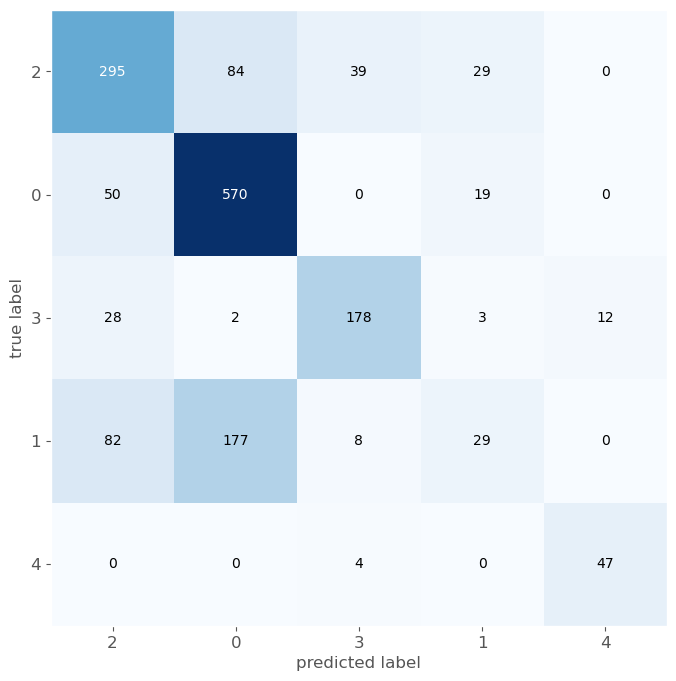

In [12]:
# Plot the confusion matrix
test_labels = np.argmax(test_label, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()

1/1 [==============================] - 1s 1s/step
A.I predicts: 1
Correct prediction for label 0 is 2


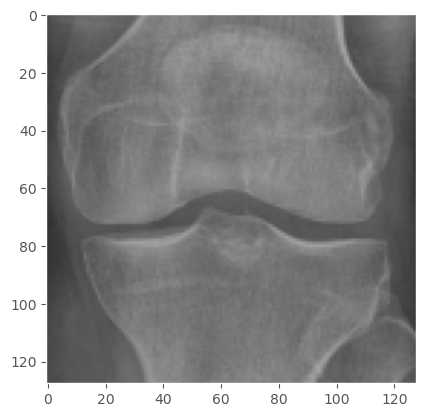

In [13]:
# Select a single image from the test set for prediction
X = 32
img_single = test_data_rgb[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

# Make prediction on the single image
predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(test_label[X]), 'is', categories[np.argmax(test_label[X])])

# Display the single image
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()
